In [1]:
# # @title 테스트용
# # 1. 데이터 다운로드 및 압축 해제
# # url = 'https://drive.google.com/file/d/1TyXOsYoTP7oqgGPqswXCd17m2pggNyOz/view?usp=drive_link'
# file_id = '1TyXOsYoTP7oqgGPqswXCd17m2pggNyOz'
# output = 'car_t.zip'

# gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=True) # (다운로드받을것, 다운로드파일이름지정, 로그확인)

# dir = 'car_t'
# os.makedirs(dir, exist_ok=True) # exist_ok -> 없으면 만들고 있어도 에러 발생 없이 넘어감

# with zipfile.ZipFile(output, 'r') as z:
#   z.extractall(dir)

### IMPORT

In [2]:
import pandas as pd
import numpy as np
import gdown, zipfile, os
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [3]:
# 1. 데이터 다운로드 및 압축 해제
import pandas as pd
import numpy as np
import gdown, zipfile, os

# url = 'https://drive.google.com/file/d/1rhXolT2ezQBT2T6RpVJwMX3uBWsbYEcV/view?usp=sharing'
file_id = '1rhXolT2ezQBT2T6RpVJwMX3uBWsbYEcV'
output = 'Car.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=True) # (다운로드받을것, 다운로드파일이름지정, 로그확인)

dir = 'car'
os.makedirs(dir, exist_ok=True) # exist_ok -> 없으면 만들고 있어도 에러 발생 없이 넘어감

with zipfile.ZipFile(output, 'r') as z:
  z.extractall(dir)

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import os

base_dir = 'car'

paths = []
dataset_types = []
labels = []

# os.walk() 특정 디렉토리 하위의 디렉토리/파일을 재귀적으로 탐색
for dir_name, sub_dirs, file_names in os.walk(base_dir):
  for file_name in file_names:
    if '.jpg' in file_name:
      file_path = f'{dir_name}/{file_name}'
      paths.append(file_path)

      if 'Training' in dir_name:
        dataset_types.append('train')
      else:
        dataset_types.append('test')

      if 'SUV' in dir_name:
        labels.append('SUV')
      elif 'Sedan' in dir_name:
        labels.append('Sedan')
      elif 'Truck' in dir_name:
        labels.append('Truck')
      else:
        labels.append('Van')


In [5]:
data_df = pd.DataFrame({
    'path': paths,
    'dataset_type': dataset_types,
    'label': labels
})

data_df.head()

,path,dataset_type,label
0,car/Car/Training/Van/Carnival/Van_Carnival_105...,train,Van
1,car/Car/Training/Van/Carnival/Van_Carnival_103...,train,Van
2,car/Car/Training/Van/Carnival/Van_Carnival_100...,train,Van
3,car/Car/Training/Van/Carnival/Van_Carnival_102...,train,Van
4,car/Car/Training/Van/Carnival/Van_Carnival_107...,train,Van


In [6]:
data_df['dataset_type'].value_counts()

,count
dataset_type,
train,51079
test,14453


In [7]:
data_df['label'].value_counts()

,count
label,
Sedan,42517
SUV,14484
Truck,4525
Van,4006


In [8]:
data_df[['dataset_type', 'label']].value_counts()

dataset_type  label
train         Sedan    33635
              SUV      11559
test          Sedan     8882
train         Truck     3879
test          SUV       2925
train         Van       2006
test          Van       2000
              Truck      646
Name: count, dtype: int64

In [9]:
# @title 이미지 시각화
from matplotlib import pyplot as plt
import cv2

def show_img(path, title=None):
  fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(32, 6))
  for i in range(8):
    img = cv2.imread(path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    if title:
      ax[i].set_title(title)
    ax[i].axis('off')
  plt.show()

SUV_paths = data_df[data_df['label'] == 'SUV']['path'].values
Sedan_paths = data_df[data_df['label'] == 'Sedan']['path'].values
Truck_paths = data_df[data_df['label'] == 'Truck']['path'].values
Van_paths = data_df[data_df['label'] == 'Van']['path'].values

show_img(SUV_paths[0:8], title='SUV')
show_img(Sedan_paths[0:8], title='Sedan')
show_img(Truck_paths[0:8], title='Truck')
show_img(Van_paths[0:8], title='Van')

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# 학습/검증/평가 메타데이터 분할
from sklearn.model_selection import train_test_split

train_df = data_df[data_df['dataset_type'] == 'train']
test_df = data_df[data_df['dataset_type'] == 'test']

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=0)

train_df.shape, val_df.shape, test_df.shape

((40863, 3), (10216, 3), (14453, 3))

In [11]:
# 데이터셋별로 ImageDataGenerator, flow_gen 객체 작업
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 299
BATCH_SIZE = 64

tr_data_gen = ImageDataGenerator(rescale=1/255.0, horizontal_flip=True)
val_data_gen = ImageDataGenerator(rescale=1/255.0)
test_data_gen = ImageDataGenerator(rescale=1/255.0)

tr_flow_gen = tr_data_gen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    class_mode='sparse', # 라벨 정수형
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_flow_gen = val_data_gen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_flow_gen = test_data_gen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 40863 validated image filenames belonging to 4 classes.
Found 10216 validated image filenames belonging to 4 classes.
Found 14453 validated image filenames belonging to 4 classes.


In [12]:
# 모델 정의

base_model = InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
# functional api
x = base_model.output # feature층의 마지막값
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 22,293,924 (85.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 274s 294ms/step - accuracy: 0.9112 - loss: 0.2629 - val_accuracy: 0.9310 - val_loss: 0.2410 - learning_rate: 0.0010
Epoch 2/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 117s 181ms/step - accuracy: 0.9736 - loss: 0.0878 - val_accuracy: 0.9541 - val_loss: 0.1560 - learning_rate: 0.0010
Epoch 3/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 118s 182ms/step - accuracy: 0.9788 - loss: 0.0696 - val_accuracy: 0.9794 - val_loss: 0.0741 - learning_rate: 0.0010
Epoch 4/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 117s 181ms/step - accuracy: 0.9833 - loss: 0.0572 - val_accuracy: 0.9566 - val_loss: 0.1396 - learning_rate: 0.0010
Epoch 5/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 117s 182ms/step - accuracy: 0.9842 - loss: 0.0550 - val_accuracy: 0.9707 - val_loss: 0.0970 - learning_rate: 0.0010
Epoch 6/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9846 - loss: 0.0526
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
639/639 ━━━━━━━━━━━━━━━━━━━━ 117s 182ms/step - accuracy: 0.9847 - l

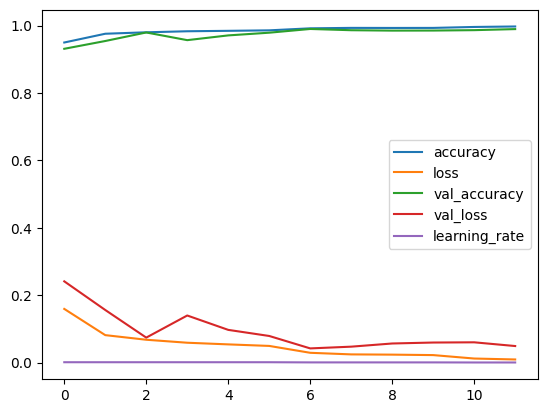

  1/226 ━━━━━━━━━━━━━━━━━━━━ 43s 194ms/step - accuracy: 1.0000 - loss: 0.0166

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


226/226 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.9924 - loss: 0.0462
loss: 0.0363, accuracy=0.9920


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = 'adam', # optimizer=Adam(learning_rate=0.001), # 객체로 변환 후 명시적으로 생성해서 사용하는 방법
    metrics=['accuracy']
)

early_stopping_cb = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

# 학습
history = model.fit(
    tr_flow_gen,
    epochs=15,
    validation_data=val_flow_gen,
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb]
)

# 학습결과 시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, accuracy = model.evaluate(test_flow_gen)
print(f'loss: {loss:.4f}, accuracy={accuracy:.4f}')

226/226 ━━━━━━━━━━━━━━━━━━━━ 30s 131ms/step - accuracy: 0.9924 - loss: 0.0462
0.03634112328290939 0.9919739961624146


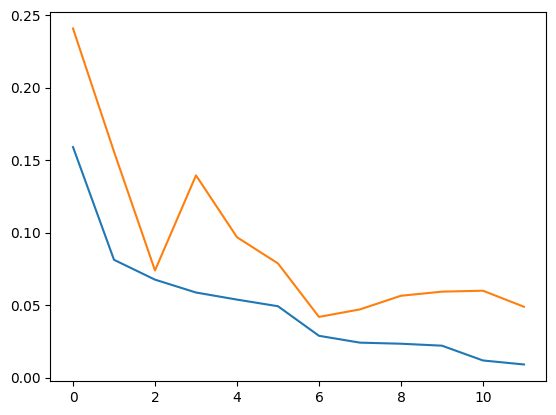

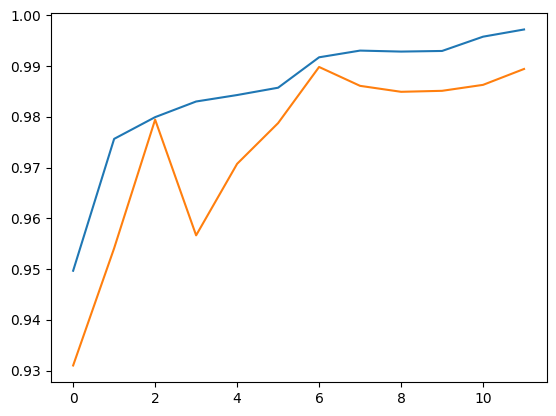

In [14]:
loss, accuracy = model.evaluate(test_flow_gen)

print(loss, accuracy)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()